In [17]:
import pandas as pd 
import pickle
import optuna
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

SEED=42

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
train = pd.read_csv('../data/modelling_data/train.csv')
valid = pd.read_csv('../data/modelling_data/valid.csv')

with open('artifacts/lightgbm_reg/lightgbm_regressor.pkl', 'rb') as fp:
    lightgbm_regressor = pickle.load(fp)
    
with open('artifacts/lightgbm_reg/study.pkl', 'rb') as fp:
    lightgbm_study = pickle.load(fp)

with open('artifacts/xgboost_reg/xgboost_regressor.pkl', 'rb') as fp:
    xgboost_regressor = pickle.load(fp)
    
with open('artifacts/xgboost_reg/study.pkl', 'rb') as fp:
    xgboost_study = pickle.load(fp)

In [3]:
def get_evaluation_metrics(y_true, y_pred):
    print('RMSE:', round(root_mean_squared_error(y_true=y_true, y_pred=y_pred),2))
    print('MAE:', round(mean_absolute_error(y_true=y_true, y_pred=y_pred),2))
    print('R2:', f'{round(100*r2_score(y_true=y_true, y_pred=y_pred),2)}%')
    print('MAPE:', f'{round(100*mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred),2)}%')
    

In [4]:
features = train.select_dtypes(include=[np.number, bool]).columns
features = [i for i in features if i not in ['prezzo', 'log_prezzo', 'log_m2'] and 'emb_' not in i]
target='prezzo'

### LightGBM

In [5]:
lightgbm_preds = lightgbm_regressor.predict(valid[features])
get_evaluation_metrics(valid[target], lightgbm_preds)

RMSE: 192628.72
MAE: 125797.28
R2: 60.76%
MAPE: 53.28%


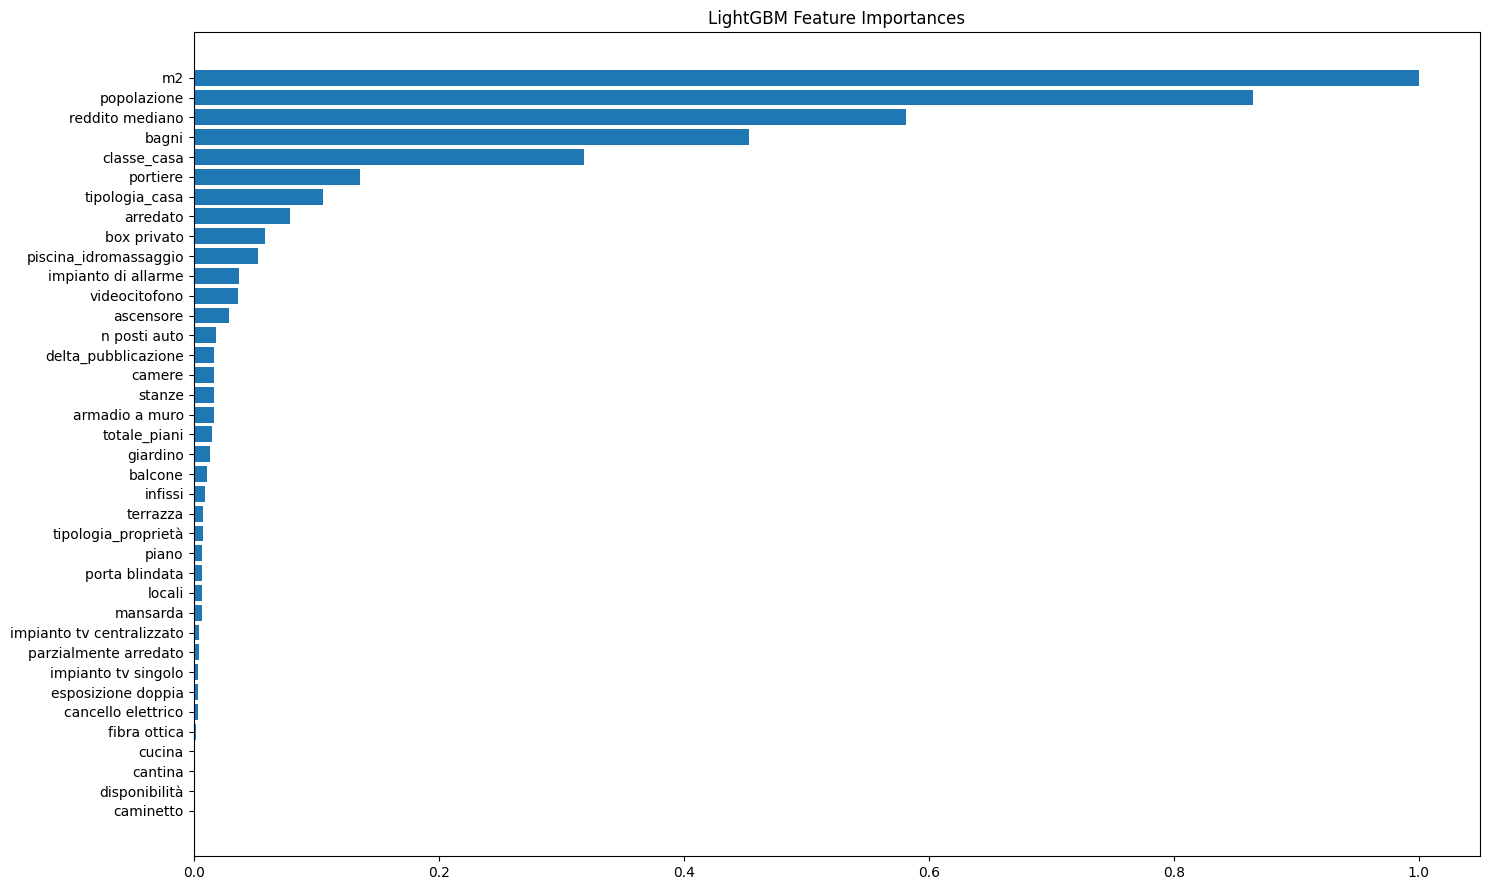

In [16]:
lightgbm_feature_imp = pd.DataFrame({'Features':features, 'Importances':lightgbm_regressor.feature_importances_}).sort_values('Importances')
lightgbm_feature_imp['Importances']/=lightgbm_feature_imp['Importances'].max()
fig, ax = plt.subplots(figsize=(15,9))
ax.barh(y=lightgbm_feature_imp['Features'], width=lightgbm_feature_imp['Importances'])
ax.set_title('LightGBM Feature Importances')
plt.tight_layout()
plt.show()

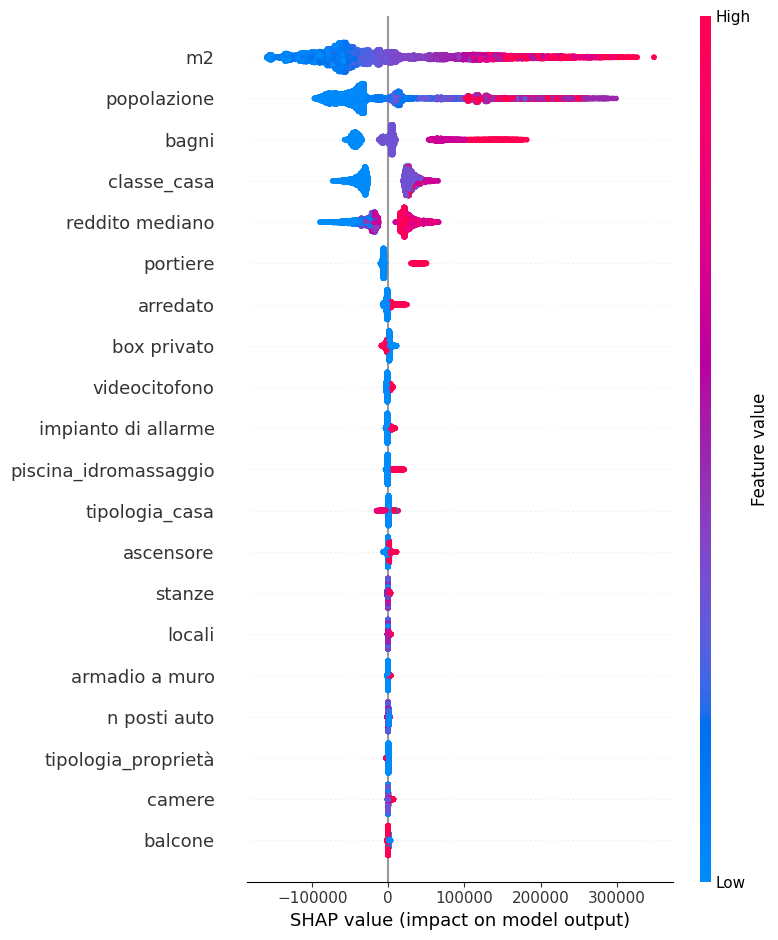

In [21]:
explainer = shap.TreeExplainer(lightgbm_regressor)
shap_values = explainer(train[features])
shap.summary_plot(shap_values, train[features])

### XGBoost

In [9]:
xgboost_preds = xgboost_regressor.predict(valid[features])
get_evaluation_metrics(valid[target], xgboost_preds)

RMSE: 198982.35
MAE: 128166.16
R2: 58.13%
MAPE: 54.56%


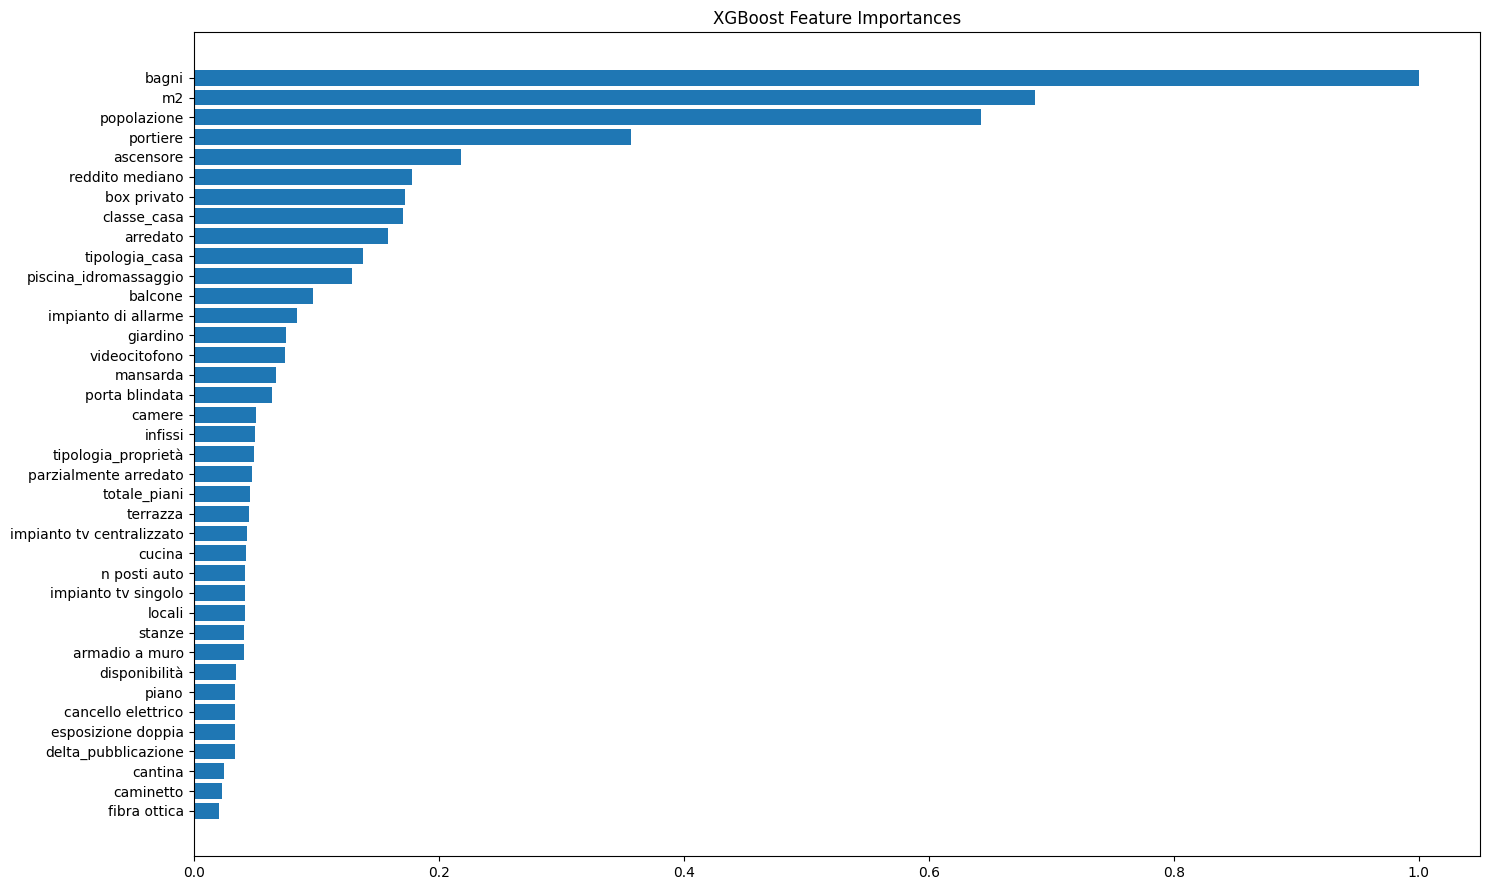

In [25]:
xgboost_feature_imp = pd.DataFrame({'Features':features, 'Importances':xgboost_regressor.feature_importances_}).sort_values('Importances')
xgboost_feature_imp['Importances']/=xgboost_feature_imp['Importances'].max()
fig, ax = plt.subplots(figsize=(15,9))
ax.barh(y=xgboost_feature_imp['Features'], width=xgboost_feature_imp['Importances'])
ax.set_title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()

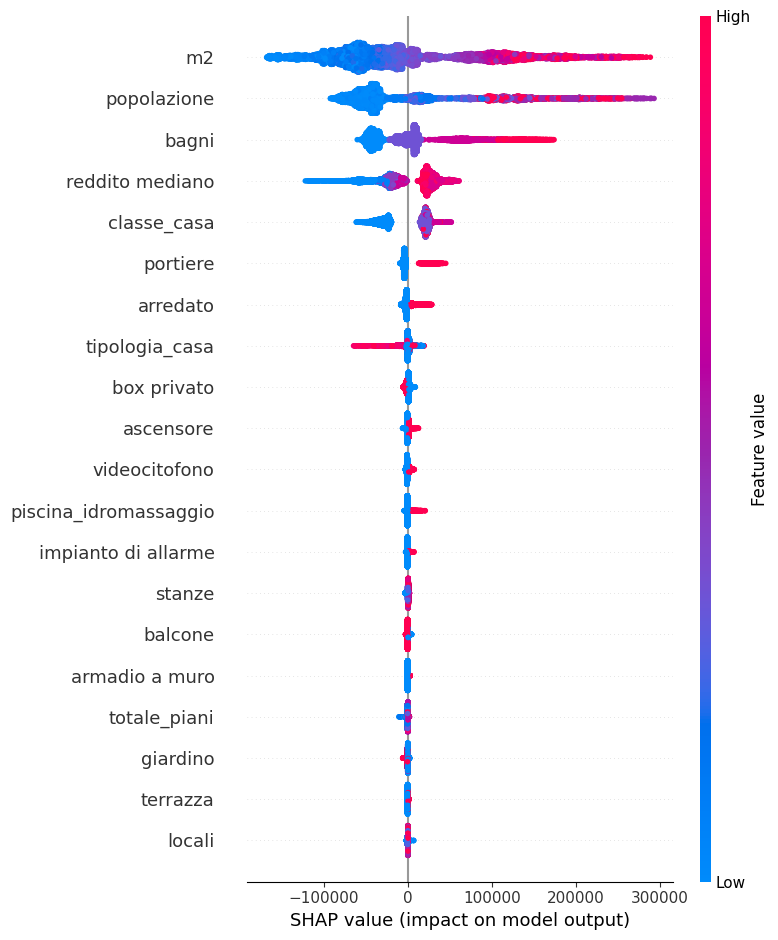

In [26]:
explainer = shap.TreeExplainer(xgboost_regressor)
shap_values = explainer(train[features])
shap.summary_plot(shap_values, train[features])